In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 14.9 MB/s 
     |████████████████████████████████| 7.6 MB 46.5 MB/s 
     |████████████████████████████████| 163 kB 70.9 MB/s 


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import EncoderDecoderModel, AdamW
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.utils.data_utils import pad_sequences
import numpy as np
import nltk
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 1. Data processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
data_path = 'drive/MyDrive/Colab Notebooks/arxiv_title_generation/'

In [ ]:
df = pd.read_csv(data_path + 'train.csv')
df

,abstract,title
0,we consider the problem of utility maximizatio...,on optimal investment with processes of long o...
1,in this paper we provide an explicit formula f...,boolean complexes for ferrers graphs
2,"kinesin-5, also known as eg5 in vertebrates is...",relative velocity of sliding of microtubules b...
3,we discuss the transition paths in a coupled b...,bifurcation of transition paths induced by cou...
4,two types of room temperature detectors of ter...,all-electric detectors of the polarization sta...
...,...,...
134995,we consider a minimalistic dynamic model of th...,randomly evolving idiotypic networks: structur...
134996,this is an extended version of a communication...,noncommutative generalization of su(n)-princip...
134997,"in this paper, a new method was developed for ...",initialization of multilayer forecasting artif...
134998,we propose a new approach to analyze data that...,principal arc analysis on direct product manif...


In [ ]:
df['abstract'] = df.abstract.apply(lambda x: "[CLS] " + x + " [SEP]")
df['title'] = df.title.apply(lambda x: "[CLS] " + x + " [SEP]")

In [ ]:
train_abstract, test_abstract, train_title, test_title = train_test_split(df.abstract, df.title, test_size=0.2)
print(len(train_abstract), len(test_abstract))

108000 27000


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
%%time
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_abstract]
tokenized_titles = [tokenizer.tokenize(sent) for sent in train_title]
print(tokenized_titles[0])

['[CLS]', 'under', '##com', '##ple', '##te', 'blind', 'subsp', '##ace', 'deco', '##n', '##vo', '##lu', '##tion', 'via', 'linear', 'prediction', '[SEP]']
CPU times: user 7min 8s, sys: 2.49 s, total: 7min 10s
Wall time: 7min 15s


In [ ]:
text_lengths = list(map(lambda x: len(x), tokenized_texts))
np.median(text_lengths), np.max(text_lengths)

(181.0, 1096)

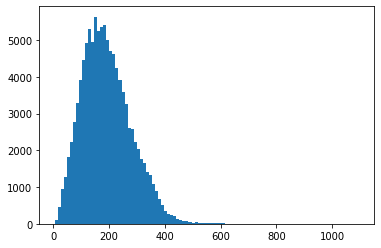

In [ ]:
plt.hist(text_lengths, bins=100)
plt.show()

In [ ]:
title_lengths = list(map(lambda x: len(x), tokenized_titles))
np.median(title_lengths), np.max(title_lengths)

(15.0, 103)

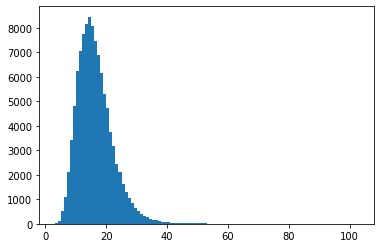

In [ ]:
plt.hist(title_lengths, bins=100)
plt.show()

In [ ]:
encoder_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
encoder_input_ids = pad_sequences(
    encoder_input_ids,
    maxlen=150,
    dtype="long",
    truncating="post",
    padding="post"
)

decoder_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_titles]
decoder_input_ids = pad_sequences(
    decoder_input_ids,
    maxlen=30,
    dtype="long",
    truncating="post",
    padding="post"
)

encoder_attention_masks = [[float(i>0) for i in seq] for seq in encoder_input_ids]
decoder_attention_masks = [[float(i>0) for i in seq] for seq in decoder_input_ids]

In [ ]:
train_enc_inputs, validation_enc_inputs, train_dec_inputs, validation_dec_inputs = train_test_split(
    encoder_input_ids, decoder_input_ids, 
    random_state=42,
    test_size=0.1
)

train_enc_masks, validation_enc_masks, train_dec_masks, validation_dec_masks = train_test_split(
    encoder_attention_masks, decoder_attention_masks,
    random_state=42,
    test_size=0.1
)

In [ ]:
train_enc_inputs = torch.tensor(train_enc_inputs)
train_dec_inputs = torch.tensor(train_dec_inputs)
train_enc_masks = torch.tensor(train_enc_masks)
train_dec_masks = torch.tensor(train_dec_masks)

In [ ]:
validation_enc_inputs = torch.tensor(validation_enc_inputs)
validation_dec_inputs = torch.tensor(validation_dec_inputs)
validation_enc_masks = torch.tensor(validation_enc_masks)
validation_dec_masks = torch.tensor(validation_dec_masks)

In [ ]:
train_data = TensorDataset(train_enc_inputs, train_dec_inputs, train_enc_masks, train_dec_masks)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=16
)

In [ ]:
validation_data = TensorDataset(validation_enc_inputs, validation_dec_inputs, validation_enc_masks, validation_dec_masks)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=16
)

## 2. Model training

In [ ]:
model = EncoderDecoderModel.from_encoder_decoder_pretrained('bert-base-uncased', 'bert-base-uncased')

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.bias', 'cls.seq_relations

In [ ]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

In [ ]:
model.cuda()

EncoderDecoderModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

Обучаемые параметры взяты по рекомендации из курса

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
## custom loss usage

criterion = nn.NLLLoss(ignore_index=tokenizer.pad_token_id)

def compute_loss(predictions, targets):
    predictions = predictions[:, :-1, :].contiguous()
    targets = targets[:, 1:]

    rearranged_output = predictions.view(predictions.shape[0]*predictions.shape[1], -1)
    rearranged_target = targets.contiguous().view(-1)

    loss = criterion(rearranged_output, rearranged_target)

    return loss

In [ ]:
def train(model, iterator, optimizer):
    
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        
        optimizer.zero_grad()
        
        batch = tuple(t.to(device) for t in batch)
        enc_ids, dec_ids, enc_mask, dec_mask = batch
        lm_labels = dec_ids.clone()
        
        outputs = model(
            input_ids=enc_ids, 
            attention_mask=enc_mask, 
            decoder_input_ids=dec_ids,
            decoder_attention_mask=dec_mask,
            labels=lm_labels   
        )
        
        prediction_scores = outputs.logits
        predictions = F.log_softmax(prediction_scores, dim=2)
        loss = compute_loss(predictions, dec_ids)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        epoch_loss += loss.item()

    print("Mean epoch loss:", (epoch_loss / len(iterator)))

In [ ]:
def evaluate(model, iterator):
    
    model.eval()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        
        optimizer.zero_grad()
        
        batch = tuple(t.to(device) for t in batch)
        enc_ids, dec_ids, enc_mask, dec_mask = batch
        lm_labels = dec_ids.clone()
        
        with torch.no_grad():
            outputs = model(
                input_ids=enc_ids, 
                attention_mask=enc_mask, 
                decoder_input_ids=dec_ids,
                decoder_attention_mask=dec_mask,
                labels=lm_labels   
            )
            
            prediction_scores = outputs.logits
            predictions = F.log_softmax(prediction_scores, dim=2)
            loss = compute_loss(predictions, dec_ids)
            epoch_loss += loss.item()

    print("Mean epoch loss:", (epoch_loss / len(iterator)))

In [ ]:
torch.cuda.empty_cache()

In [ ]:
%%time
for epoch in range(1):
    print('Epoch', epoch+1)
    train(model, train_dataloader, optimizer)
    evaluate(model, validation_dataloader)

Epoch 1


/usr/local/lib/python3.7/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:533: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Mean epoch loss: 4.104513510990535
Mean epoch loss: 3.249056334672151
CPU times: user 38min 18s, sys: 29min 11s, total: 1h 7min 29s
Wall time: 1h 7min 26s


In [ ]:
model.save_pretrained(data_path + 'bert2bert')

## 3. Model evaluation

Предобработка включает все шаги процессинга, но уже для тестовых данных. Генерация будет осуществляться встроенными методами модели.

In [ ]:
%%time
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_abstract]
tokenized_titles = [tokenizer.tokenize(sent) for sent in test_title]

CPU times: user 1min 52s, sys: 1.06 s, total: 1min 53s
Wall time: 1min 54s


In [ ]:
test_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
test_input_ids = pad_sequences(
    test_input_ids,
    maxlen=150,
    dtype="long",
    truncating="post",
    padding="post"
)

In [ ]:
test_input_ids = torch.tensor(test_input_ids)

Ниже пример сгенерированного заголовка и реальный тестовый заголовок

In [ ]:
generated_ids = model.generate(test_input_ids[0].unsqueeze(0).to(device))
generated_text = tokenizer.convert_ids_to_tokens(generated_ids[0])
print(*generated_text)
print(*tokenized_titles[0])

[CLS] a fast and accurate sequence - to - sequence translation of attention - based attention [SEP] a multi -
[CLS] expectation particle belief propagation [SEP]


Оценка модели

In [ ]:
n_gram_weights = [0.3334, 0.3333, 0.3333]
macro_bleu = 0

for input_id, target_text in tqdm(zip(test_input_ids, tokenized_titles), total=len(test_title)):
    generated_ids = model.generate(input_id.unsqueeze(0).to(device))
    generated_text = tokenizer.convert_ids_to_tokens(generated_ids[0])
    bleu_score = nltk.translate.bleu_score.sentence_bleu(
        target_text,
        generated_text,
        weights = n_gram_weights
    )    
    macro_bleu += bleu_score
macro_bleu /= len(test_title)

print('Macro-average BLEU (BERT): {0:.5f}'.format(macro_bleu))

  0%|          | 0/27000 [00:00<?, ?it/s]

Macro-average BLEU (BERT): 0.38296


## 4. Submission making

In [ ]:
test_data = pd.read_csv(data_path + 'test.csv')
test_data

,abstract
0,Most sequence transformation models use recurr...
1,The doc2vec approach was introduced as an exte...
2,LSTM models can vary greatly depending on sequ...
3,A joint learning process of alignment and tran...
4,Current unsupervised image-to-image translatio...
...,...
995,subsystem codes are the most versatile class o...
996,we study dirac-harmonic maps from degenerating...
997,in this note we study kloosterman sums twisted...
998,we obtain the rate of growth of long strange s...


In [ ]:
test_texts = test_data.abstract.apply(lambda x: "[CLS] " + x + " [SEP]")
test_text_tokenized = [tokenizer.tokenize(sent) for sent in test_data]

In [ ]:
test_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in test_text_tokenized]
test_input_ids = pad_sequences(
    test_input_ids,
    maxlen=150,
    dtype="long",
    truncating="post",
    padding="post"
)

In [ ]:
test_input_ids = torch.tensor(test_input_ids)

In [ ]:
# Очистка текста от служебных токенов и повторений
def clear_generated(generated_text):
    prev_token = ''
    result = []
    for token in generated_text.split():
        if token in (['[CLS]', '[SEP]', '[PAD]']):
            continue
        elif token == prev_token:
            continue
        else:
            prev_token = token
            result.append(token)
    return result

In [ ]:
for test_id, idx in tqdm(zip(test_input_ids, test_texts.index), total=len(test_texts)):
    generated_ids = model.generate(test_id.unsqueeze(0).to(device))
    generated_text = tokenizer.convert_ids_to_tokens(generated_ids[0])
    generated_text = tokenizer.convert_tokens_to_string(generated_text)
    generated_text = clear_generated(generated_text)
    test_data.loc[idx, 'title'] = ' '.join(generated_text)

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1301: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


In [ ]:
test_data

,abstract,title
0,Most sequence transformation models use recurr...,a fast and accurate sequence - to translation ...
1,The doc2vec approach was introduced as an exte...,a unified framework for embedding of embedding...
2,LSTM models can vary greatly depending on sequ...,lstm : a multi - layer framework for multist
3,A joint learning process of alignment and tran...,a unified framework for unsupervised attention...
4,Current unsupervised image-to-image translatio...,unsupervised image translation with unsuper
...,...,...
995,subsystem codes are the most versatile class o...,subsymmetric subsysysysysysysysysysysysysysy
996,we study dirac-harmonic maps from degenerating...,dirac - type distributions of surfaces on mani...
997,in this note we study kloosterman sums twisted...,kronecker sums and on the
998,we obtain the rate of growth of long strange s...,on the decay of decays a branching process


In [ ]:
test_data.loc[1, 'title']

'a unified framework for embedding of embeddings em'

In [ ]:
test_data.to_csv(data_path + 'my_test.csv', index=False)

In [ ]:
! wget -q https://raw.githubusercontent.com/Samsung-IT-Academy/stepik-dl-nlp/master/task11_kaggle/create_submission.py

In [ ]:
from create_submission import generate_csv

test_data.to_csv(data_path + 'my_test.csv', index=False)

In [ ]:
generate_csv(data_path + 'my_test.csv', 
             data_path + 'kaggle_pred.csv',
             data_path + 'vocs.pkl')